## Import and Load Relevant Packages and Utilities

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import filter_data, interpolate_missing_data, perform_mrqa

## Lets run MRQA analysis of a single file and plots the time-seres and RPs to do a visual check

Loading file: 405_GRP.csv


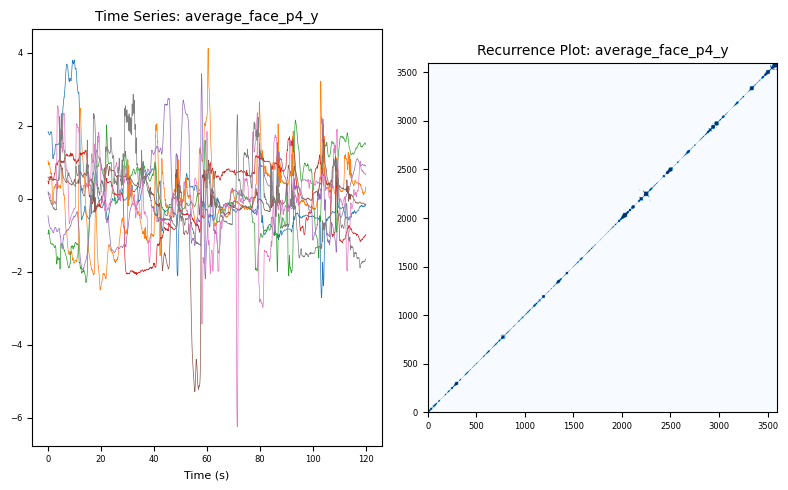

All files processed successfully!


In [11]:
# Set the directory path for the data
directory = "../../Data/Honours2024/LostAtSea/processed_csvs"  # Update this path to the correct directory

# save image (True) or not (False
save_image = True

# Get a valid participant number
part_number = 405  # Update this to the desired participant ID

# Get window size (number of frames to consider) as a function of frame rate (30 frames per second)
window_size = 30 * 120  # 2 minutes of data

# Construct the filename and file path
filename = f"{part_number}_GRP.csv"
file_path = os.path.join(directory, filename)

# Check if the file exists
if os.path.exists(file_path):
    print(f'Loading file: {filename}')

    # List of columns to analyze
    columns = [
        'average_face_p1_x', 'average_face_p1_y',
        'average_face_p2_x', 'average_face_p2_y',
        'average_face_p3_x', 'average_face_p3_y',
        'average_face_p4_x', 'average_face_p4_y'
    ]
    
    # Load the CSV file into a DataFrame
    data = pd.read_csv(file_path)
    
    # Select only the relevant columns and trim the data to the window size, removing the first 30 frames
    data = data[columns]
    data = data[window_size:window_size+window_size]

    # Interpolate missing data
    data = interpolate_missing_data(data)

    # Filter the data
    data = filter_data(data)
    
    # Z-score normalization
    data = (data - data.mean()) / data.std()

    # RQA parameters
    rqa_params = {
        'radius': 0.3,
        'minLine': 5,
        'getRP': True
    }

    # Perform RQA and obtain the results
    mrqa_result, rp_result = perform_mrqa(data, **rqa_params)

    # Initialize the plot with 4x4 subplots
    fig, axes = plt.subplots(1, 2, figsize=(8, 5))

    # Plot time series
    time = np.arange(len(data)) / 30  # Assuming data is at 30Hz
    for column in columns:
        axes[0].plot(time, data[column], linewidth=0.5)
    axes[0].set_title(f'Time Series: {column}', fontsize=10)
    axes[0].set_xlabel('Time (s)', fontsize=8)
    axes[0].tick_params(axis='both', which='major', labelsize=6)

    # Plot recurrence plot
    axes[1].imshow(rp_result.recurrence_matrix, cmap='Blues', origin='lower')
    axes[1].set_title(f'Recurrence Plot: {column}', fontsize=10)
    axes[1].tick_params(axis='both', which='major', labelsize=6)

    # Adjust layout and save the plot
    plt.tight_layout()
    if save_image:
        image_name = filename.split('.')[0]
        plt.savefig(f'images/rqa/{filename}_rp_plot.png')
    plt.show()

    print('All files processed successfully!')
else:
    print(f'File {filename} not found in directory {directory}')


## Run a Windowed RQA analysis on the data for a given set of RQA parameters

In [16]:
# Set the directory path for the data
directory = "../../Data/Honours2024/LostAtSea/processed_csvs"  # Update this path to the correct directory

# Set the frame rate and window size in seconds
fps = 30
window_size_seconds = 120  # Set window size in seconds
window_size = int(window_size_seconds * fps)  # Calculate window size in frames
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # Step size for windows

#print(f'Window size: {window_size} frames ({window_size_seconds} seconds)')
#print(f'Step size: {step_size} frames')

# Set the delay and ED parameters to iterate over
radii = [0.1, 0.2, 0.3, 0.4, 0.5]

# Initialize a list to store results for the CSV
csv_results = []

# Get the number of CSV files in the directory
num_files = len([filename for filename in os.listdir(directory) if filename.endswith('.csv')])
index = 0

# loop over each delay and embedding dimension
for radius in radii:
    # Set the RQA parameters
    rqa_params = {
        'radius': radius,
        'minLine': 5,
        'getRP': False
    }

    # Set the analysis parameters
    analysis_parameters = f"_windowSize{window_size_seconds}s_radius{rqa_params['radius']}_minLine{rqa_params['minLine']}"

    # Iterate through each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Print hyperparameters
            print(f'Hyperparameters: {rqa_params}')

            # Process the files
            file_path = os.path.join(directory, filename)

            # Load the CSV file into a DataFrame
            data = pd.read_csv(file_path)

            # Update the progress
            index += 1

            # Get group number from filename
            group_number = int(filename.split('_')[0])

            # Get condition "group" = GRP or individual = IND from file name (before .csv)
            condition = filename.split('_')[1]

            # Select only the relevant columns
            columns = [
                'average_face_p1_x', 'average_face_p1_y',
                'average_face_p2_x', 'average_face_p2_y', 
                'average_face_p3_x', 'average_face_p3_y', 
                'average_face_p4_x', 'average_face_p4_y'
            ]

            # Only use the specified columns
            data = data[columns]

            # Initialize result_row to store the average RQA metrics for this file
            result_row = {
                'filename': filename,
                'group_number': group_number,
                'condition': condition,
                'num_windows': 0
            }

            # List to store metrics for all windows
            all_metrics = []

            # skipped windows index
            skipped_windows_index = 0

            # Iterate over the data in windows with 50% overlap
            for start in range(0, len(data) - window_size + 1, step_size):
                #print(f"Processed window starting at {start}")

                # Get the window of data
                window = data[start:start + window_size]

                # Count the number of missing values in each column
                missing_counts = window.isnull().sum()

                # Check if there are more than 90 consecutive missing values in any column
                if any(window.apply(lambda col: col.isnull().astype(int).groupby(col.notnull().astype(int).cumsum()).cumsum().max() > 90)):
                    print(f"Skipping window starting at {start} as it contains more than 90 consecutive missing values")
                    skipped_windows_index += 1
                    continue

                # Interpolate missing data
                window = interpolate_missing_data(window)

                # Filter the data
                window = filter_data(window)

                # Z-score normalization
                window = (window - window.mean()) / window.std()

                # Perform RQA on the window
                rqa_result = perform_mrqa(window, **rqa_params)

                # Collect metrics for this window
                window_metrics = {}
                window_metrics[f'REC'] = rqa_result.recurrence_rate
                window_metrics[f'DET'] = rqa_result.determinism
                window_metrics[f'Lmean'] = rqa_result.average_diagonal_line
                window_metrics[f'Lmax'] = rqa_result.longest_diagonal_line
                window_metrics[f'DIV'] = rqa_result.divergence
                window_metrics[f'Lentropy'] = rqa_result.entropy_diagonal_lines
                window_metrics[f'LAM'] = rqa_result.laminarity
                window_metrics[f'TT'] = rqa_result.trapping_time
                window_metrics[f'Vmax'] = rqa_result.longest_vertical_line
                window_metrics[f'Ventropy'] = rqa_result.entropy_vertical_lines

                if window_metrics:
                    all_metrics.append(window_metrics)
                    result_row['num_windows'] += 1

            # If there are valid windows, average the metrics over all windows
            if all_metrics:
                avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
                result_row.update(avg_metrics)
                result_row['skipped_windows'] = skipped_windows_index

            # Append the results to the list
            csv_results.append(result_row)

            # Update the progress
            clear_output(wait=True)
            print(f'Processed {index}/{num_files} files')
            

    # Save results to CSV
    csv_df = pd.DataFrame(csv_results)
    csv_df.to_csv(f'analysis/mrqa/lostAtSea_mrqaAnalysis{analysis_parameters}.csv', index=False)


Processed 345/69 files


## Create Box plots for a Specified MRQA Analysis and set of MRQA Metrics

/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_5407/89590023.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})
/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_5407/89590023.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})
/var/folders/_n/5wxln6_12gb153kv9xc_63mm0000gp/T/ipykernel_5407/89590023.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cond

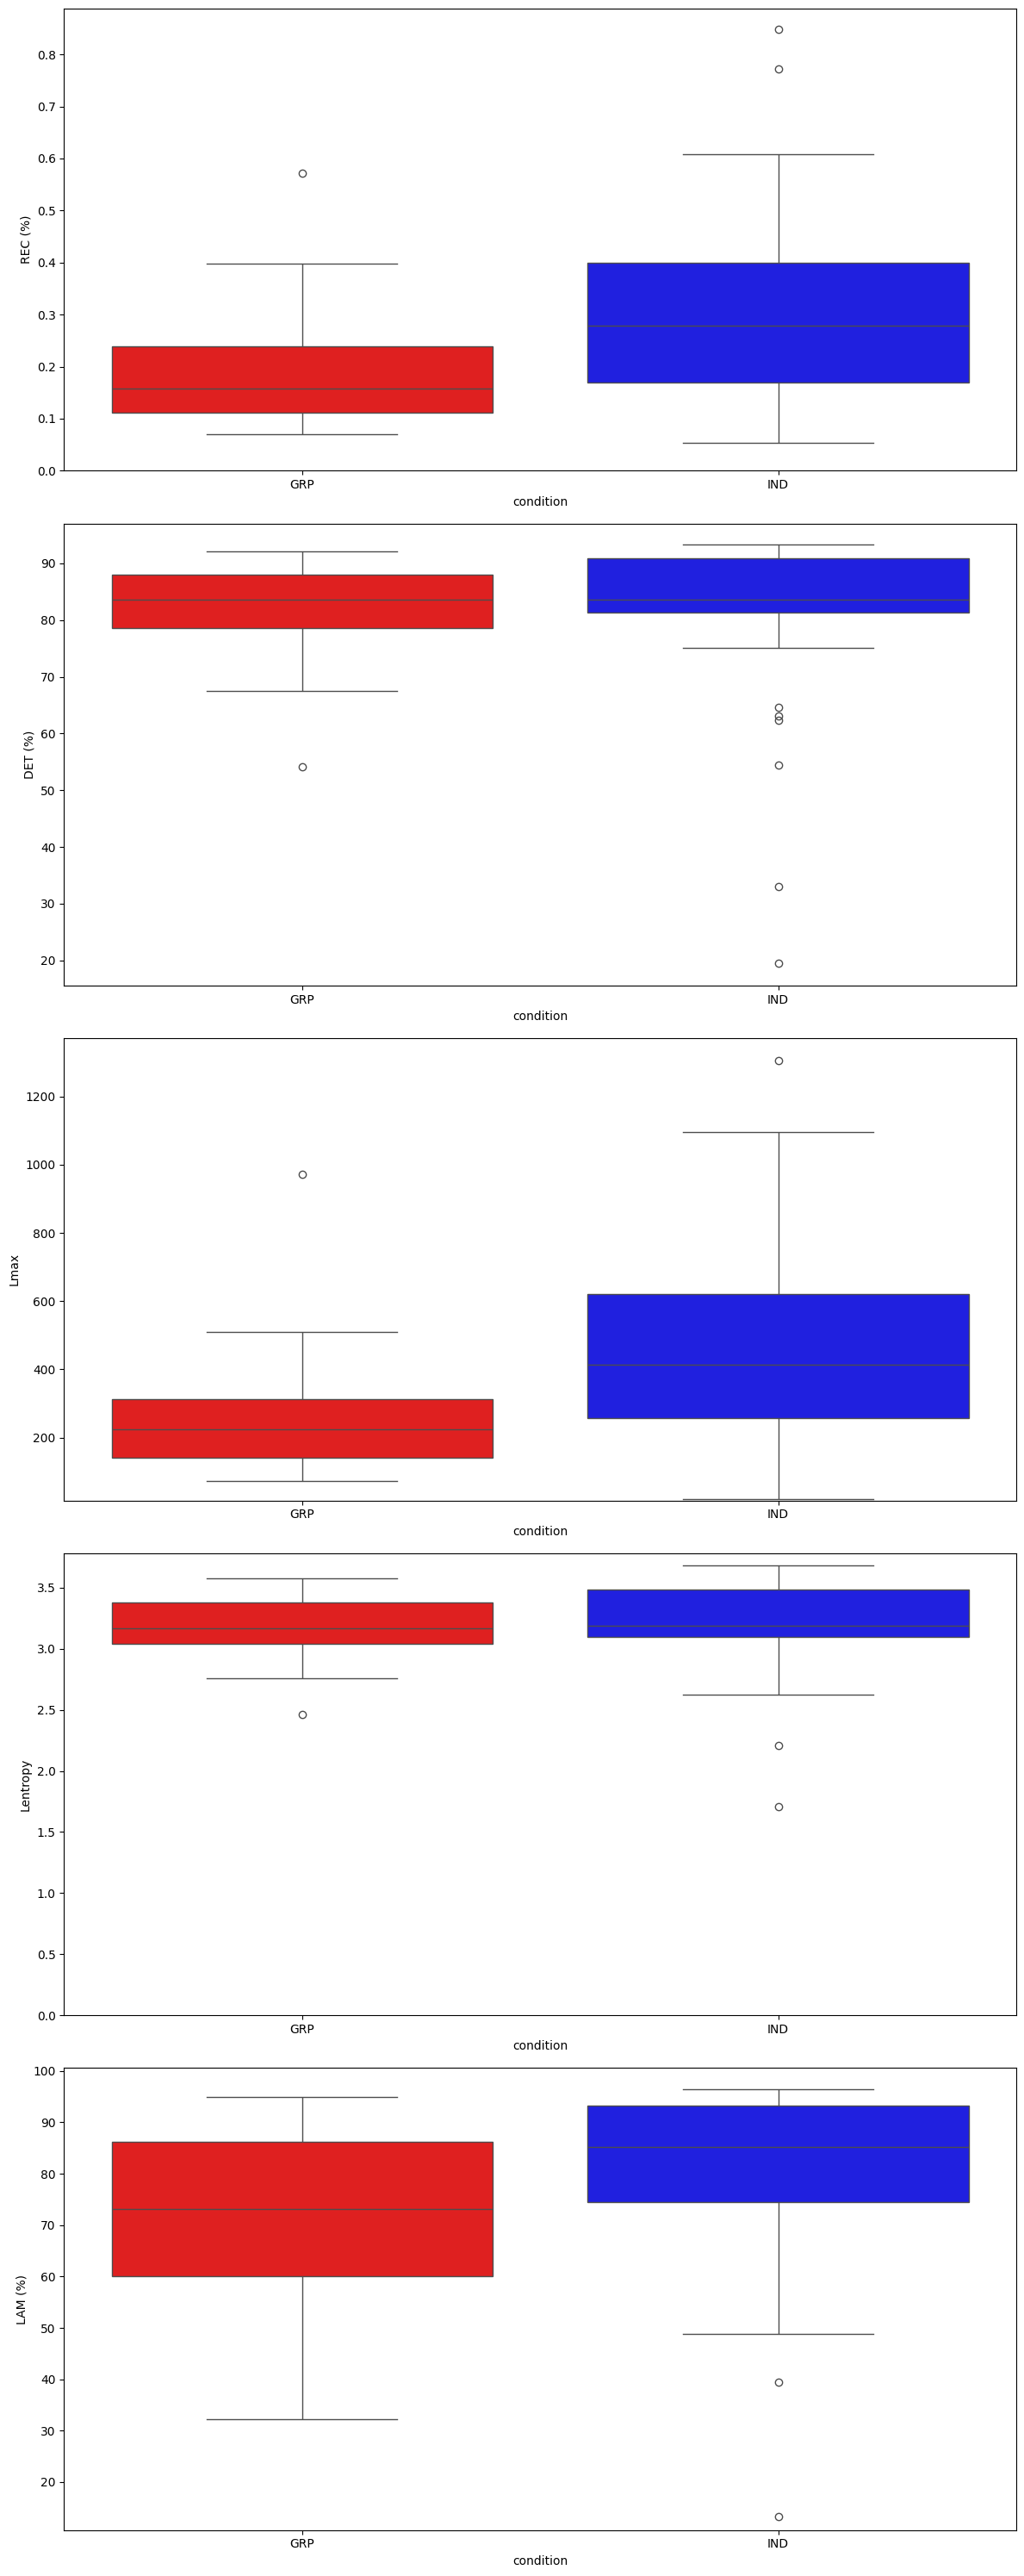

In [24]:
# Set the MRQA parameters for the analysis you would like to plot
rqa_params = {
    'radius': 0.2,
    'minLine': 5,
    'getRP': False
}

# Set the analysis parameters
analysis_parameters = f"_windowSize{window_size_seconds}s_radius{rqa_params['radius']}_minLine{rqa_params['minLine']}"

# Load the analysis results from the CSV file
csv_file = f'analysis/mrqa/lostAtSea_mrqaAnalysis{analysis_parameters}.csv'  # Update this path to the correct file
data = pd.read_csv(csv_file)

# Ensure the 'condition' column has correct values
data['condition'] = data['condition'].str.replace('.csv', '')

#------------------------------------------------------------------------------------
# REMOVE STRANGE DATA !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# There is a GRP_2 condition that should be GRP or removed. Remove it for consistency
data = data[data['condition'] != 'GRP_2']
data = data[data['group_number'] != 408]
#------------------------------------------------------------------------------------

# Specify the metrics to plot
metrics = ['REC', 'DET', 'Lmax', 'Lentropy', 'LAM']  # List of metrics to plot (e.g., recurrence rate, determinism, longest diagonal line length)

# Initialize the plot
plt.figure(figsize=(12, 6 * len(metrics)))

# Loop through each metric and create the plots
for i, metric in enumerate(metrics):
    plt.subplot(len(metrics), 1, i + 1)

    # Get the data for the metric
    plot_data = data[['condition', metric]].copy()
    plot_data.columns = ['condition', 'value']

    # Adjust y-axis label and values if the metric is less than 1
    if plot_data['value'].max() < 1:
        plot_data['value'] *= 100  # Convert to percentage
        y_label = f'{metric} (%)'
    else:
        y_label = metric

    sns.boxplot(x='condition', y='value', data=plot_data, palette={'GRP': 'red', 'IND': 'blue'})
    
    plt.ylabel(y_label)
    
    # Scale the y-axis to be slightly less than the minimum value observed
    min_val = plot_data['value'].min()
    plt.ylim(bottom=0 if min_val < 10 else min_val * 0.8)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
